In [1]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
character_directories = listdir(train_root_path)
character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))


Train: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum']
Test: ['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


In [4]:
#calculate mean width and lenght from test images
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
num_test_images = len(test_image_names)

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//num_test_images
lenght_mean = lenght//num_test_images
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [3]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

In [36]:
#make batches
def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_end):
    data = {'images':[],
            'labels':[]}
    
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(batch_init, batch_end):
            path_file = os.path.join(path, images_list[i])
            image = imread(path_file)
            image = imresize(image, (dim_size, dim_size))
            data['images'].append(image)
            data['labels'].append(character)
    
    return data

def get_batches(num_batches, batch_size):
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    print("Max number of batches:{}".format(max_num_batches))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
    
    character_batch_size = batch_size//len(character_directories)
    for i in range(num_batches):
        init = i*character_batch_size
        end = init + character_batch_size
        print("yielding...")
        
        yield get_batch(init, end)


In [37]:
#num max of samples
num_samples = get_num_of_samples()
print("Number of samples:{}".format(num_samples))

#testing generator
batch_size = 100

for a in get_batches(10, batch_size):
    print("retrieved {} images".format(len(a['images'])))

Number of samples:19413
Max number of batches:193
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images
yielding...
retrieved 100 images


In [4]:
#load images
import matplotlib.pyplot as plt

#resizing and labeling
images_train = []
labels_train = []
for _,name in enumerate(image_train_dir_names):
    path = os.path.join(directory_train_name, name)
    images_list = listdir(path)
    for i in range(len(images_list)):
        path_file = os.path.join(path, images_list[i])
        image = imread(path_file)
        image = imresize(image, (dim_size, dim_size))
        images_train.append(image)
        labels_train.append(name)

images_train_size = len(images_train)
print("Loaded {} train images".format(images_train_size))

#resizing and labeling
images = []
labels = []
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    image = imresize(image, (dim_size, dim_size))
    images.append(image)
    label = image_names[i].split('_')[:-1]
    labels.append('_'.join(label))

images_size = len(image_names)
print("Loaded {} test images".format(images_size))

Loaded 19413 train images
Loaded 990 test images


(Train) Label:krusty_the_clown, Image:9414, Shape:(150, 150, 3)


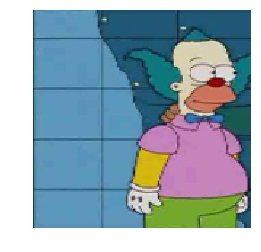

(Test) Label:kent_brockman, Image:435, Shape:(150, 150, 3)


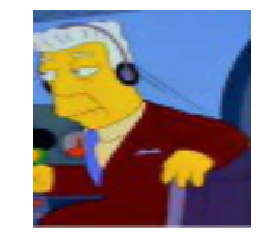

In [24]:
#show some examples
idx = random.randint(0, images_train_size)
image = images_train[idx]
print("(Train) Label:{}, Image:{}, Shape:{}".format(labels_train[idx], idx, image.shape))
plt.imshow(image)
plt.axis('off')
plt.show()

idx = random.randint(0, images_size)
image = images[idx]
print("(Test) Label:{}, Image:{}, Shape:{}".format(labels[idx], idx, image.shape))
plt.imshow(image)
plt.axis('off')
plt.show()



In [27]:
#normalize data
import numpy as np

def normalize(x):
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

images_train_norm = []
images_norm = []

sections = images_train_size//100
images_train_batches = np.array_split(np.array(images_train[:2000]), sections)

for batch in images_train_batches:
    for i in range(0, len(batch)):
        images_train_norm.append(normalize(batch[i]))

for i in range(0, images_size):
    images_norm.append(normalize(images[i]))
    
print(images_norm[1])

[[[ 0.14814815  0.42798354  0.58847737]
  [ 0.15226337  0.43209877  0.59259259]
  [ 0.15226337  0.43209877  0.58436214]
  ..., 
  [ 0.65843621  0.68312757  0.64197531]
  [ 0.65843621  0.67901235  0.65020576]
  [ 0.65432099  0.68312757  0.65020576]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67901235  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67489712  0.67078189]
  [ 0.65432099  0.67901235  0.67078189]
  [ 0.65432099  0.67901235  0.66666667]]

 ..., 
 [[ 0.41152263  0.18930041  0.0781893 ]
  [ 0.41152263  0.18930041  0.07407407]
  [ 0.41152263  0.18930041  0.07407407]
  ..., 
  [ 0.41152263  0.19341564  0.06584362]
  [ 0.41152263  0.19341564  0.06995885]
  [ 0.41563786  0.19341564  0.07818

In [28]:
#one-hot encode
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb = lb.fit(labels)

labels_train_one_hot = lb.transform(labels_train[:2000])
labels_one_hot = lb.transform(labels)

#show one-hot labels
print(lb.classes_)

#example
code = lb.transform(['marge_simpson'])
print(code)
print(lb.inverse_transform(code))


['abraham_grampa_simpson' 'apu_nahasapeemapetilon' 'bart_simpson'
 'charles_montgomery_burns' 'chief_wiggum' 'comic_book_guy'
 'edna_krabappel' 'homer_simpson' 'kent_brockman' 'krusty_the_clown'
 'lenny_leonard' 'lisa_simpson' 'marge_simpson' 'mayor_quimby'
 'milhouse_van_houten' 'moe_szyslak' 'ned_flanders' 'nelson_muntz'
 'principal_skinner' 'sideshow_bob']
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
['marge_simpson']


In [36]:
#images_norm: has the list of normalized images
#labels_one_hot: has the list of one-hot encoded labels

def get_element(elist):
    for i in range(len(elist)):
        yield elist[i]

images_train_norm = images_train_norm[:100]
images_train_arr = np.zeros((len(images_train_norm),)+ images_train_norm[0].shape )
print(images_train_arr.shape)
for e in get_element(images_train_norm):
    np.append(images_train_arr, [e], axis=0)

#images_train_norm = np.array(images_train_norm)
#labels_train_one_hot = np.array(labels_train_one_hot)
#images_norm = np.array(images_norm)
#labels_one_hot = np.array(labels_one_hot)

print("Images train shape:{}".format(images_train_arr.shape[:]))
#print("Labels train shape:{}".format(labels_train_one_hot.shape[1:]))
#print("Images test shape:{}".format(images_norm.shape[1:]))
#print("Labels test shape:{}".format(labels_one_hot.shape[1:]))

(100, 150, 150, 3)
Images train shape:(100, 150, 150, 3)


In [29]:
import tensorflow as tf

#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    #conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    #conv = tf.nn.bias_add(conv, bias_)
    #conv = tf.nn.relu(conv)
    conv = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    conv = tf.nn.bias_add(conv, bias_)
    conv = tf.nn.relu(conv)
    
    #pooling
    conv = tf.nn.max_pool(conv, pool_shape, stride_shape, padding='SAME')
    
    return conv

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [30]:
##building the network
#remove previous weights, bias, etc
tf.reset_default_graph()

#data
X = tf.placeholder(tf.float32, (None,) + images_norm.shape[1:])
y = tf.placeholder(tf.float32, (None,) + labels_one_hot.shape[1:])

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 16)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = labels_one_hot.shape[1:]

logits = classifier(flatten, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

[None, 150, 150, 3]
[None, 38, 38, 16]
[None, 10, 10, 32]
[None, 3, 3, 64]
Inputs shape: [150, 150, 3]
Flatten shape: 576
Outputs shape: 20


In [31]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [69]:
#obtaining batch with random data from dataset
def get_batches(x, y, batch_size):
    #idx = np.random.randint(x.shape[0], size=size)
    #x_batch, y_batch = x[idx,:], y[idx,:]
    
    sections = len(x)//batch_size
    return np.array_split(x, sections, axis=0), np.array_split(y, sections, axis=0)

In [77]:
##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

#train and validation
#for i in range(images_norm.shape[0]):
#    r = random.random()
#    if (r < 0.8):
#        x_train.append(images_norm[i])
#        y_train.append(labels_one_hot[i])
#    else:
#        x_val.append(images_norm[i])
#        y_val.append(labels_one_hot[i])

#x_train = np.array(x_train)
#y_train = np.array(y_train)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images_train_norm, labels_train_one_hot, test_size=0.2, random_state=42)

##
epochs = 20
batch_size = 128

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    x_batches, y_batches = get_batches(x_train, y_train, batch_size)
    for i in range(len(x_batches)):
        feed_dict = {X:x_batches[i], y:y_batches[i]}
        sess.run(optimizer, feed_dict)
        loss, acc = sess.run([cost, accuracy], feed_dict)
        print("Epoch:{} batch:{} Loss:{:.4f} Accuracy:{:.4f}".format(e, i, loss, acc))

Epoch:0 batch:0 Loss:6.4725 Accuracy:0.0985
Epoch:0 batch:1 Loss:5.2042 Accuracy:0.0303
Epoch:0 batch:2 Loss:4.3529 Accuracy:0.0682
Epoch:0 batch:3 Loss:4.6337 Accuracy:0.0606
Epoch:0 batch:4 Loss:4.7195 Accuracy:0.0379
Epoch:0 batch:5 Loss:4.2821 Accuracy:0.0530
Epoch:1 batch:0 Loss:3.9561 Accuracy:0.0455
Epoch:1 batch:1 Loss:4.3015 Accuracy:0.0682
Epoch:1 batch:2 Loss:3.9093 Accuracy:0.0455
Epoch:1 batch:3 Loss:4.0618 Accuracy:0.0682
Epoch:1 batch:4 Loss:3.6768 Accuracy:0.0606
Epoch:1 batch:5 Loss:3.6311 Accuracy:0.0758
Epoch:2 batch:0 Loss:3.3011 Accuracy:0.0833
Epoch:2 batch:1 Loss:3.4146 Accuracy:0.0758
Epoch:2 batch:2 Loss:3.2662 Accuracy:0.0606
Epoch:2 batch:3 Loss:3.3737 Accuracy:0.0682
Epoch:2 batch:4 Loss:3.3274 Accuracy:0.0303
Epoch:2 batch:5 Loss:3.1828 Accuracy:0.0833
Epoch:3 batch:0 Loss:3.0207 Accuracy:0.0682
Epoch:3 batch:1 Loss:3.1368 Accuracy:0.0530
Epoch:3 batch:2 Loss:3.0038 Accuracy:0.0909
Epoch:3 batch:3 Loss:3.0221 Accuracy:0.0909
Epoch:3 batch:4 Loss:3.1457 Accu

Label:['nelson_muntz']
Prediction: ['abraham_grampa_simpson']


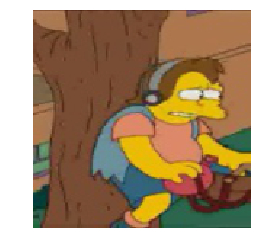

In [103]:
#prediction
idx = int(random.uniform(0, len(y_val)))
    
image_sample = x_val[idx]
label_sample = y_val[idx]
prediction = sess.run(logits, {X:[image_sample], y:[label_sample]})

prediction = lb.inverse_transform(prediction)

#showing
#image = images[idx]
lbl = np.array([label_sample])
lbl = lb.inverse_transform(lbl)
print("Label:{}".format(lbl))
print("Prediction: {}".format(prediction))

plt.imshow(image_sample)
plt.axis('off')
plt.show()